# Thermostat

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

### Original model

In [2]:
def orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = 16.
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h + noise.rsample() 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] + noise.rsample() 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj        

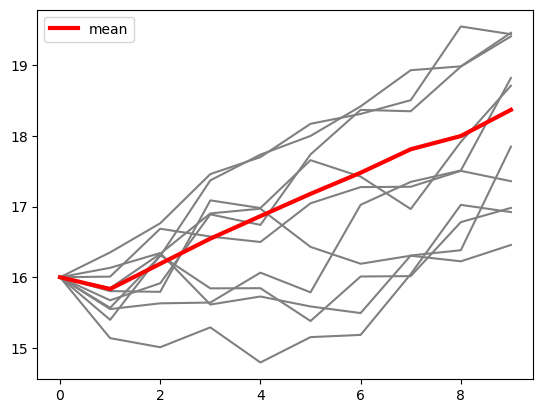

In [3]:
# generation of a set of trajectories

import matplotlib.pyplot as plt

traj_set = []
for _ in range(100):
    traj_set.append(orig_model())
traj_set = torch.vstack(traj_set)

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

### SOGA program

In [4]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)

pars = {'tOff':22., 'tOn':16.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

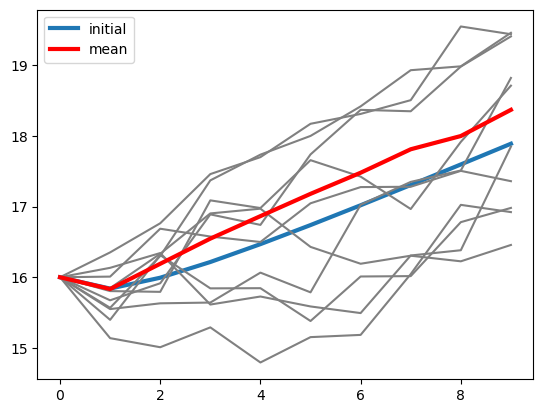

In [5]:
import matplotlib.pyplot as plt

y_init = output_dist.gm.mean()[:10].detach()
plt.plot(range(10), y_init, lw=3, label='initial')

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')
plt.legend()

In [6]:
def neg_log_likelihood(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    log_likelihood = torch.log(dist.gm.marg_pdf(traj_set[:, idx], idx))
    return - torch.sum(log_likelihood)

def L2_distance(traj_set, dist):
    idx = [1,2,3,4,5,6,7,8,9]
    output_traj = dist.gm.mean()[idx]
    return torch.sum(torch.pow(traj_set[:, idx] - output_traj,2))

neg_log_likelihood(traj_set, output_dist)
        

tensor(765.1288, grad_fn=<NegBackward0>)

In [7]:
# Define the optimizer with init_mean as the parameter

#torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

start = time()

for i in range(250):

    optimizer.zero_grad()  # Reset gradients
    
    #with torch.autograd.set_detect_anomaly(True):
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_log_likelihood(traj_set, current_dist)
        
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 25 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item()) + ' '
        out = out + f" loss: {loss.item()}"
        print(out)

end = time()

print('Optimization performed in ', round(end-start, 3))

tOff: 22.049999237060547 tOn: 16.049999237060547  loss: 765.1287841796875
tOff: 23.063600540161133 tOn: 16.84676170349121  loss: 692.14599609375
tOff: 23.42186737060547 tOn: 17.072402954101562  loss: 689.9971313476562
tOff: 23.502206802368164 tOn: 17.200883865356445  loss: 689.280517578125
tOff: 23.520809173583984 tOn: 17.28520393371582  loss: 689.0032348632812
tOff: 23.524106979370117 tOn: 17.346349716186523  loss: 688.904541015625
tOff: 23.522859573364258 tOn: 17.393268585205078  loss: 688.7938842773438
tOff: 23.520456314086914 tOn: 17.43167495727539  loss: 688.769775390625
tOff: 23.518070220947266 tOn: 17.465091705322266  loss: 688.70361328125
tOff: 23.516254425048828 tOn: 17.493343353271484  loss: 688.685302734375
Optimization performed in  454.544


In [8]:
params_dict

{'tOff': tensor(23.5150, requires_grad=True),
 'tOn': tensor(17.5171, requires_grad=True)}

In [9]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
output_dist = start_SOGA(cfg, params_dict)

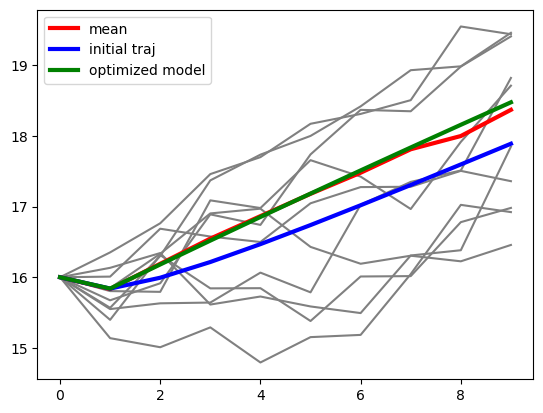

In [10]:
import matplotlib.pyplot as plt

# plotting the first ten trajectories
for i in range(10):
    plt.plot(range(10), traj_set[i], color='grey')

plt.plot(range(10), torch.mean(traj_set, 0), lw=3, color='red', label='mean')

plt.plot(range(10), y_init, lw=3, color='blue', label='initial traj')

plt.plot(range(10), output_dist.gm.mean()[:10].detach(), lw=3, color='green', label='optimized model')

plt.legend()